In [ ]:
# # Install dependencies from requirements.txt
# !pip install -r requirements_m1_5.txt


In [47]:
# !pip list

In [48]:
# from google.colab import drive
# drive.mount('/content/drive')

In [49]:
import pandas as pd

In [50]:
df=pd.read_csv("/content/user_purchase_dataset.csv")

In [51]:
df.head()

,User Type,Budget ($),Items Purchased
0,Hospital,11639,"Bandages, Catheter, Thermometer"
1,Hospital,45741,Oxygen Mask
2,Procurement Officer,5520,Scalpel
3,Clinic,6811,"Catheter, Surgical Gloves, Blood Pressure Cuff..."
4,Clinic,10359,"Sterile Gown, Surgical Gloves, Surgical Scisso..."


In [52]:
df.info()       # Check data types & nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User Type        1000 non-null   object
 1   Budget ($)       1000 non-null   int64 
 2   Items Purchased  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [53]:
df.describe()

,Budget ($)
count,1000.000000
mean,14084.199000
std,11215.844062
min,2101.000000
25%,6577.750000
50%,10253.500000
75%,16559.750000
max,49997.000000


In [54]:
print(df.isnull().sum())


User Type          0
Budget ($)         0
Items Purchased    0
dtype: int64


In [55]:
print(df['User Type'].value_counts(normalize=True))


User Type
Surgeon                0.275
Procurement Officer    0.254
Clinic                 0.240
Hospital               0.231
Name: proportion, dtype: float64


<Axes: xlabel='Budget ($)'>

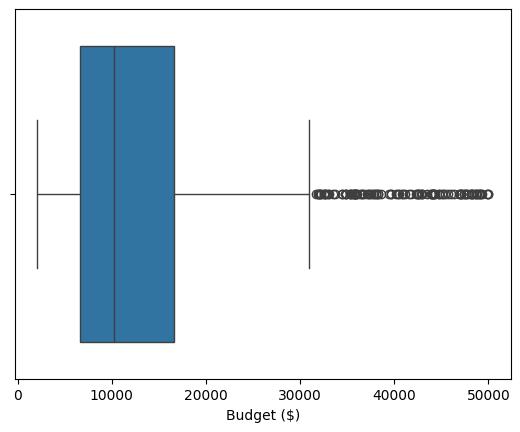

In [56]:
import seaborn as sns
sns.boxplot(x=df['Budget ($)'])


In [12]:
from collections import Counter
all_items = df['Items Purchased'].str.split(', ').sum()
print(Counter(all_items).most_common(10))


[('Blood Pressure Cuff', 183), ('Scalpel', 170), ('Needle Holder', 167), ('Thermometer', 165), ('Bandages', 164), ('Retractor', 164), ('Face Masks', 162), ('Forceps', 159), ('Syringe', 158), ('Disinfectant', 157)]


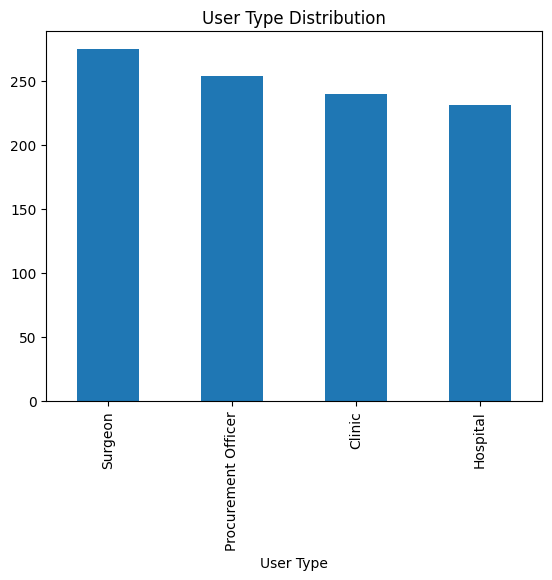

In [13]:
import matplotlib.pyplot as plt

df['User Type'].value_counts().plot(kind='bar', title='User Type Distribution')
plt.show()


# **Cosine Similarity**

In [14]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity

# # Generate dataset
# user_types = ['Hospital', 'Clinic', 'Surgeon', 'Procurement Officer']
# items = [
#     'Surgical Gloves', 'Face Masks', 'Scalpel', 'Stethoscope', 'Thermometer', 'Surgical Scissors',
#     'IV Drip', 'Bandages', 'Sterile Gown', 'Operating Table', 'Forceps', 'Retractor', 'Surgical Lights',
#     'Disinfectant', 'Needle Holder', 'Syringe', 'Monitor', 'Blood Pressure Cuff', 'Oxygen Mask',
#     'Catheter'
# ]
# budgets_range = {
#     'Hospital': (10000, 50000),
#     'Clinic': (3000, 15000),
#     'Surgeon': (2000, 10000),
#     'Procurement Officer': (5000, 20000)
# }

# records = []
# random.seed(42)
# for _ in range(1000):
#     user_type = random.choice(user_types)
#     budget = random.randint(*budgets_range[user_type])
#     purchased_items = random.sample(items, k=random.randint(1, 5))
#     records.append({
#         'User Type': user_type,
#         'Budget ($)': budget,
#         'Items Purchased': ', '.join(purchased_items)
#     })

# df = pd.DataFrame(records)


In [15]:
# One-hot encode user type
# The 'sparse' argument is deprecated and should not be used.
# By default, OneHotEncoder now returns a sparse matrix if 'sparse_output' is not set to False
encoder = OneHotEncoder(sparse_output=False)  # or handle_unknown='ignore' to ignore unknown categories
user_type_encoded = encoder.fit_transform(df[['User Type']])

# Normalize budget
scaler = MinMaxScaler()
budget_scaled = scaler.fit_transform(df[['Budget ($)']])

# TF-IDF Vectorizer for items
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(','))
items_tfidf = tfidf.fit_transform(df['Items Purchased'])

# Combine all features
features = np.hstack([user_type_encoded, budget_scaled, items_tfidf.toarray()])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [16]:
#kmeans(optional)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)


In [17]:
#dimensionality reduction
svd = TruncatedSVD(n_components=45) # Changed n_components to 45 or less, to be less than or equal to the number of features
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
features_reduced = lsa.fit_transform(features)

In [18]:
similarity_matrix = cosine_similarity(features_reduced)

def recommend_items(user_index, top_n=5):
    similar_users = np.argsort(similarity_matrix[user_index])[::-1][1:top_n+1]
    recommended_items = []
    for i in similar_users:
        recommended_items.extend(df.iloc[i]['Items Purchased'].split(', '))
    return list(set(recommended_items))


In [19]:
# Example: Recommend items for user at index 0
recommend_items(8)


['Thermometer',
 'Sterile Gown',
 'Surgical Lights',
 'Face Masks',
 'Blood Pressure Cuff']

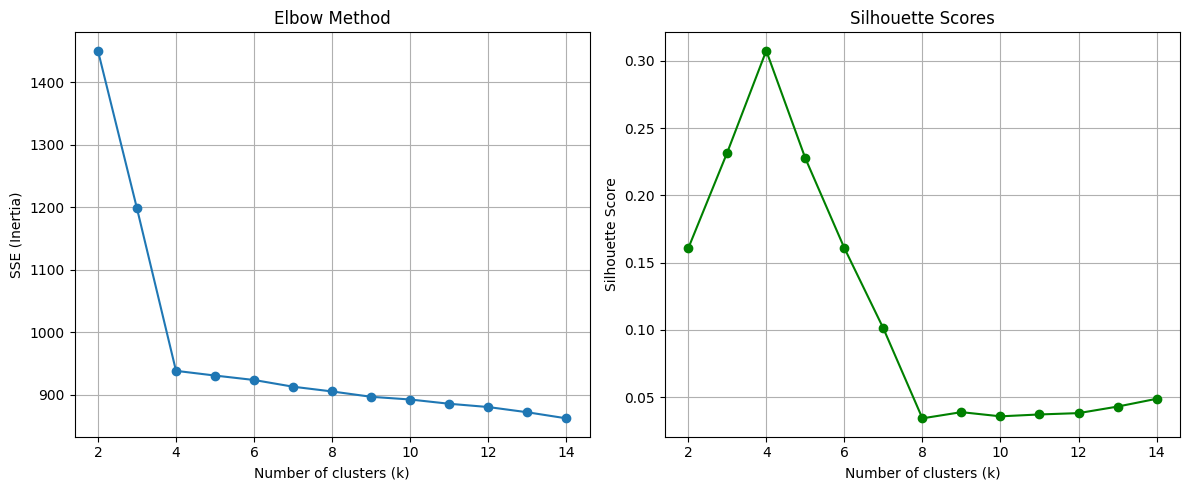

In [20]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score  # Import silhouette_score

# Assuming you have your 'features' data ready

# Calculate SSE for a range of k values
sse = []
silhouette_scores = []  # Initialize silhouette_scores list
k_range = range(2, 15)  # Range of cluster numbers to try
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features)  # Fit KMeans and get cluster labels
    sse.append(kmeans.inertia_)

    # Calculate silhouette score for current k
    silhouette_scores.append(silhouette_score(features, cluster_labels))

# Assuming you already have `sse`, `silhouette_scores`, and `k_range`

# Plot Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 15), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.grid(True)

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
from collections import Counter

all_items = df['Items Purchased'].str.split(', ').sum()  # Split and combine all items
unique_items = Counter(all_items) # Get unique items
unique_items

Counter({'Bandages': 164,
         'Catheter': 141,
         'Thermometer': 165,
         'Oxygen Mask': 139,
         'Scalpel': 170,
         'Surgical Gloves': 145,
         'Blood Pressure Cuff': 183,
         'IV Drip': 146,
         'Disinfectant': 157,
         'Sterile Gown': 152,
         'Surgical Scissors': 151,
         'Forceps': 159,
         'Stethoscope': 149,
         'Retractor': 164,
         'Face Masks': 162,
         'Needle Holder': 167,
         'Surgical Lights': 153,
         'Syringe': 158,
         'Operating Table': 135,
         'Monitor': 143})

Silhouette Score for KMeans: 0.7095


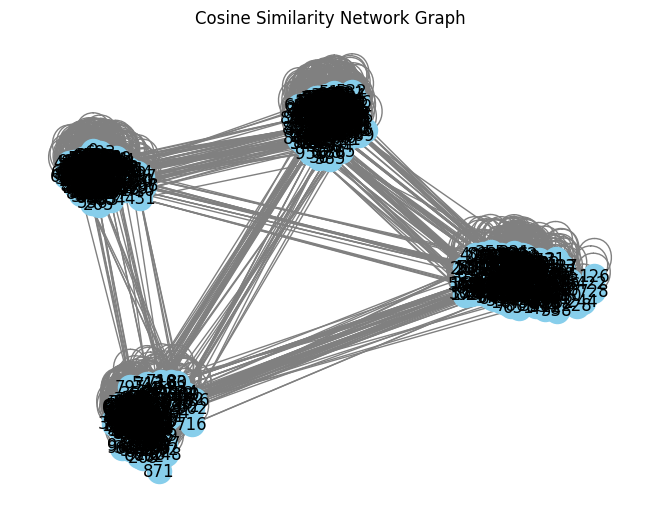

In [57]:
# Assume X is your feature matrix (users/items features)
# Example dummy data
# X = np.random.rand(100, 5)

# Cosine Similarity
cos_sim_matrix = cosine_similarity(features)

# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(cos_sim_matrix)

# Silhouette Score
silhouette = silhouette_score(cos_sim_matrix, labels)
print(f"Silhouette Score for KMeans: {silhouette:.4f}")

# Visualization
import networkx as nx

# Create a graph from the similarity matrix
G = nx.from_numpy_array(cos_sim_matrix)

# Apply a threshold to filter edges based on similarity score
threshold = 0.5
G.remove_edges_from([(u, v) for u, v, w in G.edges(data=True) if w['weight'] < threshold])

# Draw the graph
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title('Cosine Similarity Network Graph')
plt.show()


# Matrix Factorization (SVD)

In [23]:
# !pip install scikit-surprise

In [24]:
# Now import the required modules
import numpy
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy


# Prepare data for Surprise
reader = Reader(rating_scale=(0, 1))  # 1 = purchased, 0 = not purchased
df['Purchased'] = 1  # Mark all existing purchases as 1
data = Dataset.load_from_df(df[['User Type', 'Items Purchased', 'Purchased']], reader)

# Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2)

# Model
model = SVD()
model.fit(trainset)

# Predict
predictions = model.test(testset)
print('RMSE:', accuracy.rmse(predictions))


RMSE: 0.0158
RMSE: 0.015833636965724193


In [25]:
# !pip uninstall numpy scikit-surprise -y
# !pip install numpy==1.24.2 scikit-surprise
import surprise

print(f"scikit-surprise version: {surprise.__version__}")

scikit-surprise version: 1.1.4


In [26]:
# List of all unique items
all_items = df['Items Purchased'].unique()

# Choose a user (example: 'Hospital')
user = 'Hospital'

# Predict score for each item
user_predictions = [(item, model.predict(user, item).est) for item in all_items]

# Sort by highest estimated score
user_predictions.sort(key=lambda x: x[1], reverse=True)

# Top 5 recommendations
top_5 = [item for item, score in user_predictions[:5]]
print(f"Top 5 Recommendations for {user}:", top_5)


Top 5 Recommendations for Hospital: ['Scalpel', 'Sterile Gown, Surgical Gloves, Surgical Scissors, Disinfectant, Forceps', 'Forceps, Stethoscope', 'Retractor', 'Face Masks, Needle Holder, Blood Pressure Cuff']


In [27]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=5, threshold=0.5):
    # Organize predictions by user
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)  # Sort by estimated score
        top_k = user_ratings[:k]

        n_relevant = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_selected = sum((est >= threshold) for (est, _) in top_k)
        n_true_positive = sum((true_r >= threshold) for (est, true_r) in top_k)

        precision = n_true_positive / n_selected if n_selected else 0
        recall = n_true_positive / n_relevant if n_relevant else 0

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

# Calculate
precision, recall = precision_recall_at_k(predictions, k=4)
print(f'Precision@5: {precision:.4f}')
print(f'Recall@5: {recall:.4f}')


Precision@5: 1.0000
Recall@5: 0.0800


RMSE for SVD: 1.8962
MAE for SVD: 1.8402


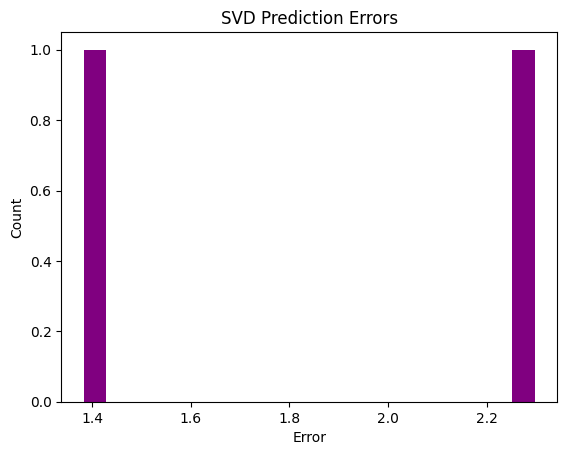

In [28]:
# Dummy ratings data
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Import the functions

ratings_dict = {
    "item": [1, 1, 1, 2, 2],
    "user": [9, 32, 2, 45, 100],
    "rating": [3, 2, 4, 3, 5],
}
df = pd.DataFrame(ratings_dict)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.25)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

# Evaluate
y_true = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions]

rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Now you can use mean_squared_error
mae = mean_absolute_error(y_true, y_pred) # Now you can use mean_absolute_error

print(f"RMSE for SVD: {rmse:.4f}")
print(f"MAE for SVD: {mae:.4f}")

# Visualization
errors = np.abs(np.array(y_true) - np.array(y_pred))
plt.hist(errors, bins=20, color='purple')
plt.title('SVD Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

# Deep Learning Embeddings

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [30]:

# Get original dataframe back
df = pd.read_csv("/content/user_purchase_dataset.csv")

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['User Encoded'] = user_encoder.fit_transform(df['User Type'])
df['Item Encoded'] = item_encoder.fit_transform(df['Items Purchased'])

n_users = df['User Encoded'].nunique()
n_items = df['Item Encoded'].nunique()

In [31]:
X = df[['User Encoded', 'Item Encoded']].values
y = np.ones(len(X))  # Dummy target (all interactions are positive)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
user_input = tf.keras.layers.Input(shape=(1,))
item_input = tf.keras.layers.Input(shape=(1,))

user_embedding = tf.keras.layers.Embedding(n_users, 32)(user_input)
item_embedding = tf.keras.layers.Embedding(n_items, 32)(item_input)

user_vec = tf.keras.layers.Flatten()(user_embedding)
item_vec = tf.keras.layers.Flatten()(item_embedding)

dot_product = tf.keras.layers.Dot(axes=1)([user_vec, item_vec])
output = tf.keras.layers.Activation('sigmoid')(dot_product)

model = tf.keras.models.Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [34]:
import tensorflow as tf

# Check if GPU is available and set device accordingly
if tf.config.list_physical_devices('GPU'):
    print("GPU is available. Using GPU for training.")
    device = '/GPU:0'
else:
    print("GPU is not available. Using CPU for training.")
    device = '/CPU:0'

# Ensure X_train and y_train data types are compatible with TensorFlow
X_train = X_train.astype(np.int32)
y_train = y_train.astype(np.float32)

# Use the determined device for training
with tf.device(device):  # Force execution on the appropriate device
    model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=5, batch_size=32, validation_split=0.1)

GPU is available. Using GPU for training.
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5292 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7817 - loss: 0.6909 - val_accuracy: 0.5250 - val_loss: 0.6928
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9563 - loss: 0.6870 - val_accuracy: 0.5500 - val_loss: 0.6914
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9935 - loss: 0.6783 - val_accuracy: 0.5750 - val_loss: 0.6885
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.6615 - val_accuracy: 0.5625 - val_loss: 0.6830


In [35]:
# Ensure X_test data type is compatible with TensorFlow
X_test = X_test.astype(np.int32)

scores = model.predict([X_test[:, 0], X_test[:, 1]])


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [36]:
user_id = 0  # Suppose we pick user with ID 0
item_ids = np.arange(n_items)

user_array = np.full(shape=len(item_ids), fill_value=user_id)
predictions = model.predict([user_array, item_ids])

top_items = predictions.flatten().argsort()[-5:][::-1]  # Top 5 items
recommended_items = item_encoder.inverse_transform(top_items)

# Get unique top 5 recommendations
seen_items = set()
top_5 = []
for item, score in user_predictions:
    if item not in seen_items:
        top_5.append(item)
        seen_items.add(item)
        if len(top_5) == 5:
            break  # Stop when we have 5 unique items

print(f"Top 5 Recommendations for {user}:", top_5)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Top 5 Recommendations for User Clinic: ['Surgical Scissors'
 'Surgical Scissors, Blood Pressure Cuff, Surgical Gloves, Needle Holder, IV Drip'
 'Catheter, Monitor' 'Sterile Gown, Blood Pressure Cuff, Retractor'
 'Retractor, Disinfectant, Surgical Scissors, Thermometer, IV Drip']


In [37]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)


X_train shape: (800, 2)
y_train shape: (800,)
X_train dtype: int32
y_train dtype: float32


In [38]:
print(df.isnull().sum())


User Type          0
Budget ($)         0
Items Purchased    0
User Encoded       0
Item Encoded       0
dtype: int64


In [39]:
print("Unique User Encoded:", df['User Encoded'].nunique())
print("Unique Item Encoded:", df['Item Encoded'].nunique())


Unique User Encoded: 4
Unique Item Encoded: 789


In [40]:
from sklearn.metrics import precision_score, recall_score
# Suppose we have top_k_preds and true_items lists
# Use binary relevance format (1 for correct rec)
precision = precision_score(top_items, top_k_preds, average='micro')
recall = recall_score(top_items, top_k_preds, average='micro')


NameError: name 'precision_score' is not defined

# LightFM

In [41]:
#prepare the datset for lightFM
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset

# Your existing dataframe (df)
# Columns: 'User Type', 'Budget ($)', 'Items Purchased'

# Create a unique user ID by combining User Type + an index
df['User ID'] = df['User Type'] + '_' + df.index.astype(str)

# Flatten (User ID, Item) pairs
user_item_pairs = []
for idx, row in df.iterrows():
    user_id = row['User ID']
    items = row['Items Purchased'].split(', ')
    for item in items:
        user_item_pairs.append((user_id, item))

# Create a dataset
dataset = Dataset()

# Fit dataset with users and items
users = df['User ID'].unique()
items = set([item for pair in user_item_pairs for item in [pair[1]]])

dataset.fit(users=users, items=items)

# Build the interactions matrix
(interactions, weights) = dataset.build_interactions(user_item_pairs)


In [42]:
# Initialize LightFM model
model = LightFM(loss='warp')  # WARP = good for ranking tasks (recommendations)

# Train the model
model.fit(interactions, epochs=30, num_threads=2)


In [43]:
# Pick a random user
n_users, n_items = interactions.shape
user_id = np.random.randint(0, n_users)

# Predict scores for all items for this user
scores = model.predict(user_id, np.arange(n_items))

# Top 5 recommended items
top_items = np.argsort(-scores)[:5]

# Mapping back to item labels
item_labels = dict(dataset.mapping()[2])  # Item mappings
reverse_item_labels = {v: k for k, v in item_labels.items()}

recommended_items = [reverse_item_labels[i] for i in top_items]
print(f"Recommended items for User {user_id}:", recommended_items)


Recommended items for User 23: ['Operating Table', 'Stethoscope', 'Oxygen Mask', 'Scalpel', 'Retractor']


Precision@K for LightFM: 0.9100
Recall@K for LightFM: 0.0907
AUC for LightFM: 0.7667


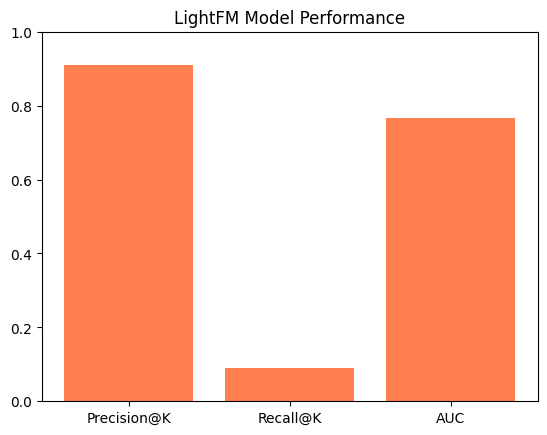

In [46]:
# Dummy sparse interactions
from scipy.sparse import coo_matrix
from lightfm.evaluation import precision_at_k # Import precision_at_k
from lightfm.evaluation import recall_at_k # Import recall_at_k
from lightfm.evaluation import auc_score # Import auc_score
import matplotlib.pyplot as plt
interactions = coo_matrix(np.random.randint(0, 2, (100, 100)))

model = LightFM(loss='warp')
model.fit(interactions, epochs=10, num_threads=2)

# Evaluate
precision_lfm = precision_at_k(model, interactions, k=5).mean()
recall_lfm = recall_at_k(model, interactions, k=5).mean()
auc_lfm = auc_score(model, interactions).mean()

print(f"Precision@K for LightFM: {precision_lfm:.4f}")
print(f"Recall@K for LightFM: {recall_lfm:.4f}")
print(f"AUC for LightFM: {auc_lfm:.4f}")

# Visualization
metrics = {'Precision@K': precision_lfm, 'Recall@K': recall_lfm, 'AUC': auc_lfm}
plt.bar(metrics.keys(), metrics.values(), color='coral')
plt.title('LightFM Model Performance')
plt.ylim(0, 1)
plt.show()


In [45]:
import pandas as pd
import numpy as np
import random
import matplotlib
import seaborn as sns
from collections import Counter
import tensorflow as tf
import surprise
import sklearn
import lightfm
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")  # Assuming 'sklearn' is used
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"tensorflow version: {tf.__version__}")
print(f"LightFM version: {lightfm.__version__}")  # Assuming 'lightfm' is used
print(f"scikit-surprise version: {surprise.__version__}")

pandas version: 2.2.2
numpy version: 1.26.0
scikit-learn version: 1.4.2
matplotlib version: 3.8.4
seaborn version: 0.13.2
tensorflow version: 2.18.0
LightFM version: 1.17
scikit-surprise version: 1.1.4
